# Logistic Regression (Revision)
**Recitation by Dr. Duygu Ataman**

_03/01/2024, 09:30, 14:00 at Room 150_

_03/01/2024, 10:45, 13:30 Office Hours at Room 524 (For any follow-up questions)_

In these lab sessions, we will be using Jupyter notebooks running on Google Colab, which has most Python libraries installed.

This notebook aims to revise logistic regression models using PyTorch and pandas libraries in the weather forecasting and flower recognition applications.

## Weather prediction

Previous recitation introduced the elements of a traditional machine learning pipeline through a weather forecasting application in PyTorch. The data set of weather recordings from New York City is collected from [Open-Meteo](https://open-meteo.com/) between 2016 to 2022 in the column-separated file 'NYC_Weather_2016_2022.csv'. Today we will revise the exercises and complete the discussion on the design of logistic regression model. We will work on two exercises that use the logistic regression for binary and multi-class classification and also discuss an optional exercise on how to implement gradient descent from scratch with logistic regression. The final exercise will be optional based on your time and preference to revise the pipeline we typically use with built-in PyTorch functionalities.

Let's revisit the solution of the exercise which implemented linear regression model with the mean squared error loss.

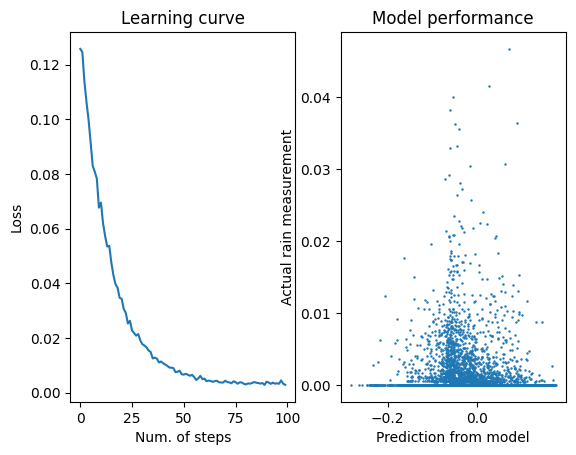

In [3]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt


class WeatherDataset(Dataset):
  def __init__(self, train_in, train_out):
        # Initialize data
        self.n_samples = train_in.shape[0]

        # here the first column is the class label, the rest are the features
        self.x_data = train_in # size [n_samples, n_features]
        self.y_data = train_out # size [n_samples, 1]

  # support indexing such that dataset[i] can be used to get i-th sample
  def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

  # we can call len(dataset) to return the size
  def __len__(self):
      return self.n_samples

class LinearRegression(torch.nn.Module):
    def __init__(self, inputSize, outputSize):
        super(LinearRegression, self).__init__()
        self.linear = torch.nn.Linear(inputSize, outputSize) # a default Linear projection layer with weights A and bias B s.t. y = A*x + b

    def forward(self, x):
        y = self.linear(x)
        return y

def process_csv(filename):
  df = pd.read_csv(filename)

  # Filter data and apply normalization
  df = df.dropna()
  datatensor = torch.tensor(df.values[1:,1::].astype(float))
  datatensor = torch.nn.functional.normalize(datatensor)

  # Randomly select 80% of the examples for training,
  # remaining 20% will be for testing
  train, test = torch.utils.data.random_split(datatensor, [0.8, 0.2])
  traindata = torch.stack([t for t in train])
  testdata = torch.stack([t for t in test])

  # We can create separate tensors to input and output to the model
  train_in = torch.cat([traindata[:,0:2], traindata[:,3::]], dim=1)
  test_in = torch.cat([testdata[:,0:2], testdata[:,3::]], dim=1)
  train_out = traindata[:,2].unsqueeze(1) # we will use 3rd column as target prediction
  test_out = testdata[:,2].unsqueeze(1)
  return train_in, train_out, test_in, test_out


def train(model, loss, optimizer, \
          trainingData, \
          learning_rate, steps, batch_size):

  loader = iter(DataLoader(dataset=trainingData, batch_size=batch_size, shuffle=True))

  losses = []; step = 0
  for step in range(0, steps):
    input, target = next(loader)
    optimizer.zero_grad() # reset gradiant value to zero
    model.double()
    output = model(input) # pass input to model
    err = loss(output, target) # compute mean squared error between model prediction and target value
    losses.append(err) # store err value to monitor training

    err.backward() # evaluate the gradient
    optimizer.step() # propagate the evaluated gradient to update parameters

    #print('step {}, loss {}'.format(step, err.item()))
  return losses

if __name__ == '__main__':
  dataset = 'NYC_Weather_2016_2022.csv'
  train_in, train_out, test_in, test_out = process_csv(dataset)
  trainingData = WeatherDataset(train_in, train_out)

  learning_rate = 0.01
  steps = 100
  batch_size = 256

  model = LinearRegression(inputSize=8, outputSize=1)
  loss = torch.nn.MSELoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

  losses = train(model, loss, optimizer, trainingData, learning_rate, steps, batch_size)

  plt.subplot(1, 2, 1)
  plt.plot(range(steps), torch.stack(losses).detach())
  plt.title('Learning curve')
  plt.xlabel('Num. of steps')
  plt.ylabel('Loss')

  with torch.no_grad(): # this signal informs torch that further operations will not need the gradient computation
    predictions = model(test_in)
    plt.subplot(1, 2, 2)
    plt.xlabel('Prediction from model')
    plt.ylabel('Actual rain measurement')
    plt.title('Model performance')
    plt.plot(predictions, test_out, 'o', markersize=.75)

## Experiment 1

Using the provided example, plot 9 different plots for the model learning curves by ranging the batchsize in range $\{32, 64, 128\}$, and the learning rate in range $\{0.005, 0.01, 0.05\}$. At each time, observe and comment on how the change of hyperparameter affects different properties of the learning curve (e.g. the shape, the smoothness or sharpness).

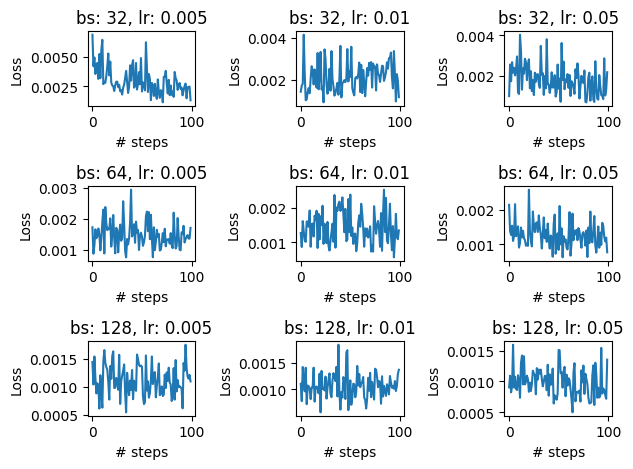

In [4]:
## Solution ##
fig, axs = plt.subplots(3, 3)

def experiment1():

  model = LinearRegression(inputSize=8, outputSize=1)
  loss = torch.nn.MSELoss()
  steps = 100

  for i, batch_size in enumerate([32, 64, 128]):
    for j, learning_rate in enumerate([0.005, 0.01, 0.05]):
      optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
      losses = train(model, loss, optimizer, trainingData, learning_rate, steps, batch_size)

      axs[i][j].plot(range(steps), torch.stack(losses).detach())
      axs[i][j].set_title('bs: {}, lr: {}'.format(batch_size, learning_rate))
      axs[i][j].set_xlabel('# steps')
      axs[i][j].set_ylabel('Loss')


  plt.tight_layout()
  plt.show()

experiment1()


## Experiment 2

Implement a Python application for rain prediction in New York City using the data set and provided functions for data processing and linear regression which uses the mean absolute error as the loss function. You may use any PyTorch functions.

Mean absolute error is defined as:

$$
 MAE(x, y) = \frac{1}{n} \sum_{i=1}^n |y_i - x_i|
$$

Plot the prediction vs. actual rain measurement plots for the different models.

**Note**: Each model might have different hypermaparameters optimal for their convergence. You can use the variables $learning_rate$ and $steps$ which are inputs to the training function to tune the optimal training hyperparameters of your regression model.

The min. squared error in training is:  tensor(0.0614, dtype=torch.float64, grad_fn=<MeanBackward0>)


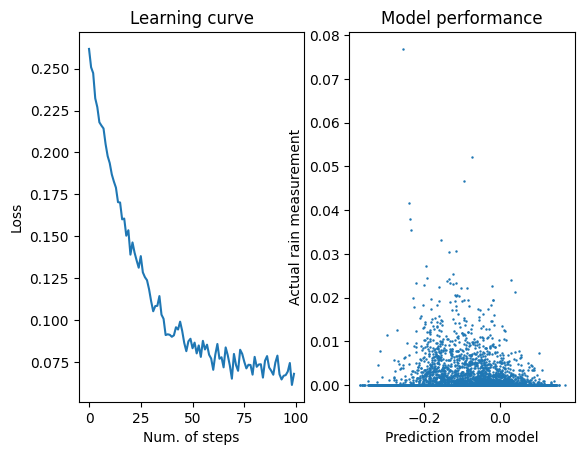

In [6]:
## Solution ##

def experiment2():
  dataset = 'NYC_Weather_2016_2022.csv'
  train_in, train_out, test_in, test_out = process_csv(dataset)
  trainingData = WeatherDataset(train_in, train_out)

  learning_rate = 0.005
  steps = 100
  batch_size = 256

  model = LinearRegression(inputSize=8, outputSize=1)
  loss = torch.nn.L1Loss()
  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

  losses = train(model, loss, optimizer, trainingData, learning_rate, steps, batch_size)
  print("The min. squared error in training is: ", min(losses))

  plt.subplot(1, 2, 1)
  plt.plot(range(steps), torch.stack(losses).detach())
  plt.title('Learning curve')
  plt.xlabel('Num. of steps')
  plt.ylabel('Loss')

  with torch.no_grad(): # this signal informs torch that further operations will not need the gradient computation
    predictions = model(test_in)
    plt.subplot(1, 2, 2)
    plt.xlabel('Prediction from model')
    plt.ylabel('Actual rain measurement')
    plt.title('Model performance')
    plt.plot(predictions, test_out, 'o', markersize=.75)

experiment2()


## Takes from our initial experiments

1. If the model by design does not ensure a restriction on the correct range of outputs, there will be no way for the model to learn that range by itself. It will be our job as machine learning scientists to ensure that the design is consistent with the requirements of the target application from every theoretical and practical sense.
2. Repeated runs of the model may yield unstable results of the experimental settings are non-deterministic.
3. There is no one setting that works for every data set and model. Each model and data set will need its own **specific set of optimal hyper-parameters** to learn from that **specific dataset** using that **specific model**.

Rethinking our pipeline, we'll start by addressing the model design. Theoretically, the range of values of the input $x$ and output $y$ of a linear regression model

$$
  y = A*x + b
$$

is the $\mathbb{R}$.

In our application, the rain measurement values are in the range $[0, 1]$ since we have normalized them. In order to inform the model of this restriction, we can extend the model equation with an additional layer using an **activation function**.

## Logistic function

A typical function that could restrict the range of values produced by a linear projection module is the **logistic** function which takes a range of real values and transforms them into the range of values in $[0, 1]$.

$$
  \sigma (x) = \frac{e^x}{1 + e^x}
$$

(0.0, 1.0)

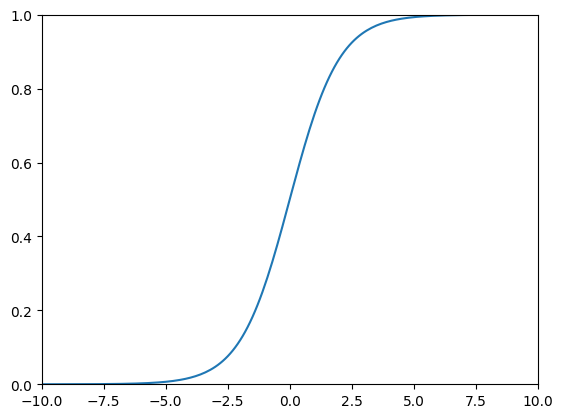

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import math

xi = np.arange(-10, 10, 0.1)
y = [ math.exp(x) / (1 + math.exp(x)) for x in xi]

plt.plot(xi, y)
plt.xlim(-10, 10)
plt.ylim(0, 1)


In [8]:
class LogisticRegression(torch.nn.Module):
    def __init__(self, inputSize, outputSize):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(inputSize, outputSize, bias=True) # a default Linear projection layer with weights A and bias B s.t. y = A*x + b
        self.act = torch.nn.Sigmoid()

    def forward(self, x):
        y = self.linear(x)
        z = self.act(y)
        return z

We can try to test how the output range will now change.

The min. squared error in training is:  tensor(0.0065, dtype=torch.float64, grad_fn=<MseLossBackward0>)


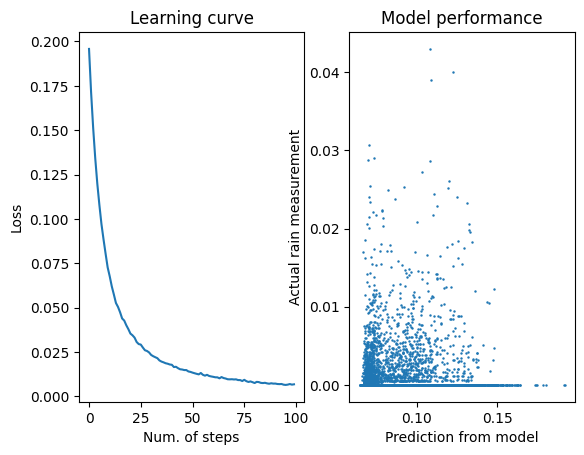

In [9]:
def experiment3():
  dataset = 'NYC_Weather_2016_2022.csv'
  train_in, train_out, test_in, test_out = process_csv(dataset)
  trainingData = WeatherDataset(train_in, train_out)

  learning_rate = 0.3
  steps = 100
  batch_size = 256

  model = LogisticRegression(inputSize=8, outputSize=1)
  loss = torch.nn.MSELoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

  losses = train(model, loss, optimizer, trainingData, learning_rate, steps, batch_size)
  print("The min. squared error in training is: ", min(losses))


  plt.subplot(1, 2, 1)
  plt.plot(range(steps), torch.stack(losses).detach())
  plt.title('Learning curve')
  plt.xlabel('Num. of steps')
  plt.ylabel('Loss')

  with torch.no_grad(): # this signal informs torch that further operations will not need the gradient computation
    predictions = model(test_in)
    plt.subplot(1, 2, 2)
    plt.xlabel('Prediction from model')
    plt.ylabel('Actual rain measurement')
    plt.title('Model performance')
    plt.plot(predictions, test_out, 'o', markersize=.75)

experiment3()

Note that our model has only 8 input features, thus, an 8x1 $A$ matrix for predicting the linear projection $y = A*x $ weight of each feature. If we wanted to understand how these features are weighted at each prediction, we could try to visualize their values.

In [10]:
df = pd.read_csv('NYC_Weather_2016_2022.csv')
print(list(df.columns[1:3]) + list(df.columns[4::]))
print(model.linear.weight)

['temperature_2m (°C)', 'precipitation (mm)', 'cloudcover (%)', 'cloudcover_low (%)', 'cloudcover_mid (%)', 'cloudcover_high (%)', 'windspeed_10m (km/h)', 'winddirection_10m (°)']
Parameter containing:
tensor([[ 0.0984,  0.2640,  0.0853,  0.1343, -0.3561, -0.0135, -0.1398,  0.0221]],
       dtype=torch.float64, requires_grad=True)


In [11]:
predictions = torch.where(predictions > 0, 1.0, 0.0)
test_out = torch.where(test_out > 0, 1.0, 0.0)

print("Accuracy of prediction is: ", torch.sum(predictions == test_out)/test_out.shape[0])


Accuracy of prediction is:  tensor(0.2618)



**Accuracy** is the percentage of all correctly classified examples in our test set.  

A more refined analysis can be performed using **the confusion matrix**:
$$
C = \begin{bmatrix}
\text{Predict 0, Actual 0} & \text{Predict 0, Actual 1}\\
\text{Predict 1, Actual 0} & \text{Predict 1, Actual 1}
\end{bmatrix}
$$

Notice that the diagonal entries are the examples that are correctly classified.  

The most useful classification metrics are **Precision** and **Recall**. If we define a prediction $C_{ij}$ which belongs to class i for which we estimated the label i, we calculate them as follows.

#### Precision Score
The precision score is the percentage
$$
\text{Precision}_0 = \frac{C_{00}}{C_{00} + C_{01}}
$$

$$
\text{Precision}_1 = \frac{C_{11}}{C_{11} + C_{10}}
$$
which is the percentage of predicted rain possibility that we classify correctly.  

#### Recall Score
The recall score is the percentage
$$
\textrm{Recall}_0 = \frac{C_{00}}{C_{00} + C_{10}}
$$
$$
\textrm{Recall}_1 = \frac{C_{11}}{C_{11} + C_{01}}
$$
which is the percentage of rain possibility that we classify correctly. Note that Precision and Recall are two different quantities.

**Using multiple evaluation metrics helps give a better picture of how well our classifier is doing.**

## Exercise 1

Using the different features in the weather measurement data set, train an individual logistic regression model on each of the individual measurements:
- 'temperature_2m (°C)'
- 'precipitation (mm)'
- 'cloudcover (%)'
- 'windspeed_10m (km/h)'
- 'winddirection_10m (°)'

Plot the learning curve and predictions for the 5 different models each trained on a different set of measurements.
Calculate the binary rain prediction accuracy, precision and recall.

In [13]:
## Your solution ##

def process_csv_onefeature(dataset, featureid): # new input sets the column we would like to use as input feature
  ## To-do: Update to return only one-dimensional features
  df = pd.read_csv(dataset)

  # Filter data and apply normalization
  df = df.dropna()
  datatensor = torch.tensor(df.values[1:,1::].astype(float))
  datatensor = torch.nn.functional.normalize(datatensor)

  # Randomly select 80% of the examples for training,
  # remaining 20% will be for testing
  train, test = torch.utils.data.random_split(datatensor, [0.8, 0.2])
  traindata = torch.stack([t for t in train])
  testdata = torch.stack([t for t in test])

  # We can create separate tensors to input and output to the model
  train_in = traindata[:,featureid].unsqueeze(1)
  test_in = testdata[:,featureid].unsqueeze(1)
  train_out = traindata[:,2].unsqueeze(1) # we will use 3rd column as target prediction
  test_out = testdata[:,2].unsqueeze(1)
  return train_in, train_out, test_in, test_out


def experiment4():
  dataset = 'NYC_Weather_2016_2022.csv'

  features = [0, 1, 3, 4, 7, 8] # 'temperature_2m (°C)', 'precipitation (mm)', 'cloudcover (%)', 'windspeed_10m (km/h)', 'winddirection_10m (°)'
  for i in features:
    train_in, train_out, test_in, test_out = process_csv2_onefeature(dataset, featureid=i)
    trainingData = WeatherDataset(train_in, train_out)

    learning_rate = 0.3
    steps = 100
    batch_size = 256

    model = LogisticRegression(inputSize=1, outputSize=1)
    loss = torch.nn.MSELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    losses = train(model, loss, optimizer, trainingData, learning_rate, steps, batch_size)
    print("The min. squared error in training is: ", min(losses))

    plt.subplot(1, 2, 1)
    plt.plot(range(steps), torch.stack(losses).detach())
    plt.title('Learning curve')
    plt.xlabel('Num. of steps')
    plt.ylabel('Loss')

    with torch.no_grad(): # this signal informs torch that further operations will not need the gradient computation
      predictions = model(test_in)
      plt.subplot(1, 2, 2)
      plt.xlabel('Prediction from model')
      plt.ylabel('Actual rain measurement')
      plt.title('Model performance')
      plt.plot(predictions, test_out, 'o', markersize=.75, color=(i/8.0, 1-i/8.0, i/16.0+0.5))

    # To-do: Compute accuracy, precision, recall
    predictions = torch.where(predictions > 0, 1.0, 0.0)
    test_out = torch.where(test_out > 0, 1.0, 0.0)

    print("Accuracy of prediction is: ", torch.sum(predictions == test_out)/test_out.shape[0])
    precision = torch.logical_and(predictions, test_out).sum() / (predictions == 1).sum()
    recall = torch.logical_and(predictions, test_out).sum() / (test_out == 1).sum()
    print("Precision: ", precision)
    print("Recall: ", recall)

experiment4()

NameError: name 'process_csv2_onefeature' is not defined

While the activation functions can help refine the range of target output, the ultimate estimation of the underlying function $y = f(x)$ that helps learn the data distribution depends on the loss function. Least squares may help in many prediction tasks, but for predicting the probability of any future event, we can rely on the **cross-entropy** function.

Cross-entropy essentially measures the similarity between two probability distributions. Here, $y$ represents the underlying function we are trying estimate using the data:

$$\mathcal{L}(x,y) = - ( y \cdot \log(p_{+}) + (1 - y) \cdot \log(1 - p_{+}) )$$

and $p_+$ in our application will represent the predicted probability of observing rain (the positive event) measured using the weather data set.
Note that $p_{+}$ depends on $x$ and the model parameters.


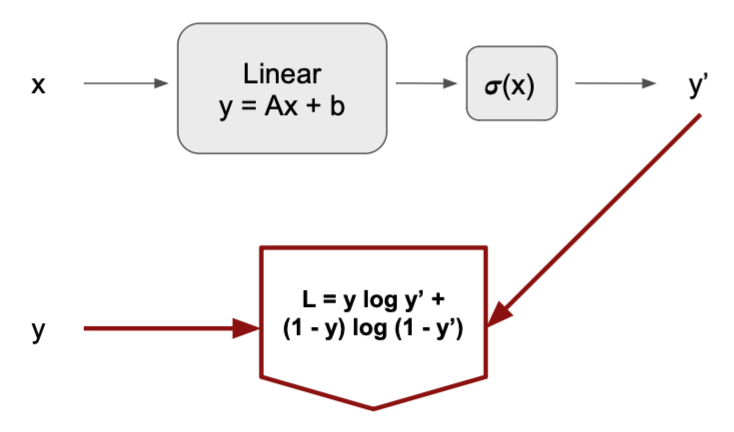


## Exercise 2: Binary Cross-entropy

We can now finalize our logistic regression model with the cross-entropy loss. If we want to predict the probability of rain, now we need to change our target data from rain measurement to binary values representing the presence of rain.

In the next exercise, change the loss function to binary cross-entropy and the output labels to binary values. Plot the learning curve and predictions for the model using all features and display the model weights corresponding to each input feature. Repeat the experiment for the models using individual features. Calculate the accuracy, precision and recall at each case.

The loss function at each step in training is:  tensor(0.2710, dtype=torch.float64, grad_fn=<BinaryCrossEntropyBackward0>)
The average chance of rain is:  tensor(0.1359, dtype=torch.float64)
Accuracy of prediction is:  tensor(0.6315)
Precision:  tensor(0.2620)
Recall:  tensor(0.9284)


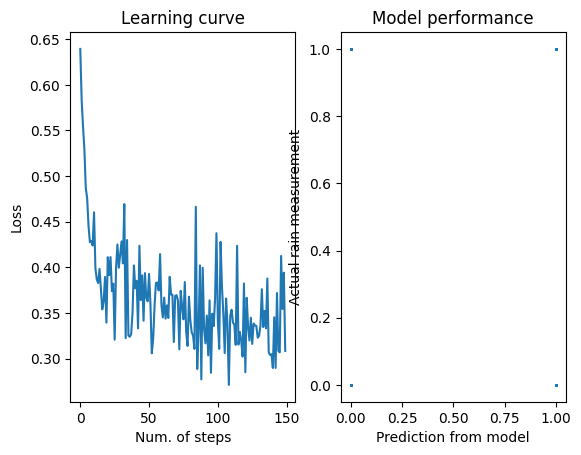

In [14]:
def experiment5():

  dataset = 'NYC_Weather_2016_2022.csv'
  train_in, train_out, test_in, test_out = process_csv(dataset)
  train_out = (train_out > 0).double()
  test_out = (test_out > 0).double()

  trainingData = WeatherDataset(train_in, train_out)

  learning_rate = 0.3
  steps = 150
  batch_size = 256

  model = LogisticRegression(inputSize=8, outputSize=1)
  loss = torch.nn.BCELoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

  losses = train(model, loss, optimizer, trainingData, learning_rate, steps, batch_size)
  print("The loss function at each step in training is: ", min(losses))


  plt.subplot(1, 2, 1)
  plt.plot(range(steps), torch.stack(losses).detach())
  plt.title('Learning curve')
  plt.xlabel('Num. of steps')
  plt.ylabel('Loss')

  with torch.no_grad(): # this signal informs torch that further operations will not need the gradient computation
    model_output = model(test_in)
    print("The average chance of rain is: ", model_output.mean())
    predictions = (model_output > 0.1)
    plt.subplot(1, 2, 2)
    plt.xlabel('Prediction from model')
    plt.ylabel('Actual rain measurement')
    plt.title('Model performance')
    plt.plot(predictions, test_out, 'o', markersize=.75)

    print("Accuracy of prediction is: ", torch.sum(predictions == test_out)/test_out.shape[0])
    precision = torch.logical_and(predictions, test_out).sum() / (predictions == 1).sum()
    recall = torch.logical_and(predictions, test_out).sum() / (test_out == 1).sum()
    print("Precision: ", precision)
    print("Recall: ", recall)

experiment5()

The min. squared error in training is:  tensor(0.3350, dtype=torch.float64, grad_fn=<BinaryCrossEntropyBackward0>)
The average chance of rain is:  tensor(0.1430, dtype=torch.float64)
Accuracy of prediction is:  tensor(0.1307)
Precision:  tensor(0.1304)
Recall:  tensor(1.)
The min. squared error in training is:  tensor(0.3200, dtype=torch.float64, grad_fn=<BinaryCrossEntropyBackward0>)
The average chance of rain is:  tensor(0.1365, dtype=torch.float64)
Accuracy of prediction is:  tensor(0.1392)
Precision:  tensor(0.1392)
Recall:  tensor(1.)
The min. squared error in training is:  tensor(0.3248, dtype=torch.float64, grad_fn=<BinaryCrossEntropyBackward0>)
The average chance of rain is:  tensor(0.1404, dtype=torch.float64)
Accuracy of prediction is:  tensor(0.1404)
Precision:  tensor(0.1404)
Recall:  tensor(1.)
The min. squared error in training is:  tensor(0.3147, dtype=torch.float64, grad_fn=<BinaryCrossEntropyBackward0>)
The average chance of rain is:  tensor(0.1378, dtype=torch.float64

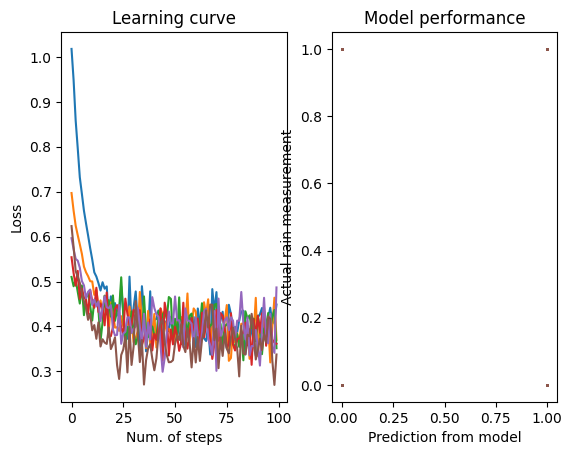

In [16]:
## Your solution ##
def process_csv_onefeature(dataset, featureid): # new input sets the column we would like to use as input feature
  ## To-do: Update to return only one-dimensional features
  df = pd.read_csv(dataset)

  # Filter data and apply normalization
  df = df.dropna()
  datatensor = torch.tensor(df.values[1:,1::].astype(float))
  datatensor = torch.nn.functional.normalize(datatensor)

  # Randomly select 80% of the examples for training,
  # remaining 20% will be for testing
  train, test = torch.utils.data.random_split(datatensor, [0.8, 0.2])
  traindata = torch.stack([t for t in train])
  testdata = torch.stack([t for t in test])

  # We can create separate tensors to input and output to the model
  train_in = traindata[:,featureid].unsqueeze(1)
  test_in = testdata[:,featureid].unsqueeze(1)
  train_out = traindata[:,2].unsqueeze(1) # we will use 3rd column as target prediction
  test_out = testdata[:,2].unsqueeze(1)
  return train_in, train_out, test_in, test_out

def experiment6():
  dataset = 'NYC_Weather_2016_2022.csv'

  features = [0, 1, 3, 4, 7, 8] # 'temperature_2m (°C)', 'precipitation (mm)', 'cloudcover (%)', 'windspeed_10m (km/h)', 'winddirection_10m (°)'
  for i in features:
    train_in, train_out, test_in, test_out = process_csv_onefeature(dataset, i)
    train_out = (train_out > 0).double()
    test_out = (test_out > 0).double()
    trainingData = WeatherDataset(train_in, train_out)

    learning_rate = 0.3
    steps = 100
    batch_size = 256

    model = LogisticRegression(inputSize=1, outputSize=1)
    loss = torch.nn.BCELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    losses = train(model, loss, optimizer, trainingData, learning_rate, steps, batch_size)
    print("The min. squared error in training is: ", min(losses))

    plt.subplot(1, 2, 1)
    plt.plot(range(steps), torch.stack(losses).detach())
    plt.title('Learning curve')
    plt.xlabel('Num. of steps')
    plt.ylabel('Loss')

    with torch.no_grad(): # this signal informs torch that further operations will not need the gradient computation
      model_output = model(test_in)
    print("The average chance of rain is: ", model_output.mean())
    predictions = (model_output > 0.1)
    plt.subplot(1, 2, 2)
    plt.xlabel('Prediction from model')
    plt.ylabel('Actual rain measurement')
    plt.title('Model performance')
    plt.plot(predictions, test_out, 'o', markersize=.75)

    print("Accuracy of prediction is: ", torch.sum(predictions == test_out)/test_out.shape[0])
    precision = torch.logical_and(predictions, test_out).sum() / (predictions == 1).sum()
    recall = torch.logical_and(predictions, test_out).sum() / (test_out == 1).sum()
    print("Precision: ", precision)
    print("Recall: ", recall)


experiment6()

## Exercise 3 (optional): Multi-class classification

In this exercise, we will implement a logistic regression model on multi-class classification. We will use the [Iris](https://scikit-learn.org/stable/datasets/toy_dataset.html#iris-plants-dataset) flower data set which contains different physical properties from three related species of Iris flowers collected by Edgar Anderson. It was first used by British statistician and biologist Ronald Fisher in 1936 for his pioneering study on linear discriminant analysis [1].

<div>
<img src="https://upload.wikimedia.org/wikipedia/commons/5/56/Kosaciec_szczecinkowaty_Iris_setosa.jpg" width="200"/>
<img src="https://upload.wikimedia.org/wikipedia/commons/4/41/Iris_versicolor_3.jpg" width="200" />
  <img src="https://upload.wikimedia.org/wikipedia/commons/9/9f/Iris_virginica.jpg" width="200" />
</div>

*Images from Wikipedia.*

[1] Fisher, R.A. “The use of multiple measurements in taxonomic problems” Annual Eugenics, 7, Part II, 179-188 (1936).

We can load the data set automatically using the [sklearn](https://scikit-learn.org/stable/) library.

In [17]:
from sklearn.datasets import load_iris
import pandas as pd

iris_data = load_iris()
df = pd.DataFrame(iris_data.data, columns=iris_data.feature_names)
df['target'] = pd.Series(iris_data.target)

df


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


We can start by doing some analysis. Please write a short analysis code to count how many samples are there from each class of flower. Plot the count as a bar graph.

Number of examples:  150


<BarContainer object of 3 artists>

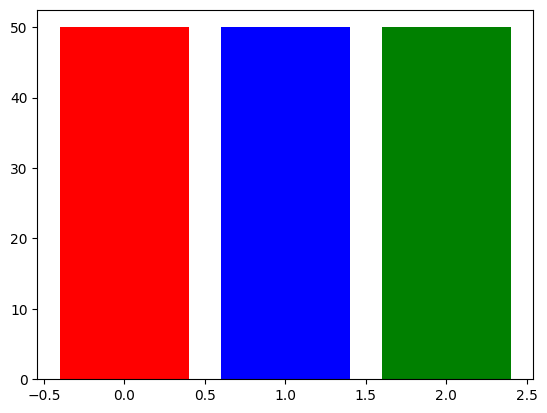

In [20]:
## To-do: Count the number of classes and plot.

## To-do: Use matplotlib.bar() to plot a bar graph.
N = len(df)
print("Number of examples: ", N)

plt.figure()
plt.bar([0, 1, 2], df['target'].value_counts(ascending= True), color = ["r", "b", "g"])

Next, we will create a training and testing split. Please process the data to convert to tensors and store as training and testing tensors. Make sure the data is numeric and clean. Note that we also need to define the input and output to our classification model.

In [37]:
## To-do: Write data processing and splitting routine
df = df.dropna()

datatensor = torch.tensor(df.values)
# print(datatensor.shape)

train, test = torch.utils.data.random_split(datatensor, [0.8, 0.2])
# print(train)
# print(test)

traindata = torch.stack([t for t in train])
testdata = torch.stack([t for t in test])
print("-----------------------------")
print(traindata.shape)
print(testdata.shape)
print("-----------------------------")

train_in = traindata[:, 0:4]
test_in = testdata[:, 0:4]

train_out = traindata[:, 4]
test_out = testdata[:, 4]


print(train_in.shape)
print(train_in[0, :])
print("-----------------------------")
print(test_in.shape)
print(test_in[0, :])
print("-----------------------------")

print(train_out.shape)
print(train_out[0])
print("-----------------------------")
print(test_out.shape)
print(test_out[0])
print("-----------------------------")

# Now we want to make the output to be a 3d tensor, as it contains 3 different classes we might want to predict
# We can do that in terms of the probability distribution


# num_classes = len(np.unique(datatensor[4]))

# # Convert to one-hot encoding
# tensor_one_hot = np.eye(num_classes)[datatensor[4]]

# # Reshape to 3D tensor
# tensor_3d = tensor_one_hot[..., np.newaxis]

# print("Original 1D tensor:")
# print(tensor_1d)
# print("\n3D tensor:")
# print(tensor_3d)



-----------------------------
torch.Size([120, 5])
torch.Size([30, 5])
-----------------------------
torch.Size([120, 4])
tensor([6.2000, 2.9000, 4.3000, 1.3000], dtype=torch.float64)
-----------------------------
torch.Size([30, 4])
tensor([5.0000, 3.6000, 1.4000, 0.2000], dtype=torch.float64)
-----------------------------
torch.Size([120])
tensor(1., dtype=torch.float64)
-----------------------------
torch.Size([30])
tensor(0., dtype=torch.float64)
-----------------------------


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

Define a logistic regression model and create a training routine to train the model on the training data. Plot the learning curve. Make sure the training is stable and model converges by tuning the hyperparameters, including the batch size and learning rate.

In [ ]:
## To-do: Implement the model and create training routine.
from torch.utils.data import Dataset, DataLoader, RandomSampler

class IrisDataset(Dataset):
    def __init__(self, train_in, train_out):
        self.n_samples = train_in.shape[0]
        self.x_data = train_in
        self.y_data = train_out

    def __getitem__(self, index):
        return x_data[index], self.y_data[index]

    def __len__(self):
        return self.n_samples


class LogisticRegression(torch.nn.Module):
    def __init__(self, inputsize, outputsize):
        self.linear = torch.nn.Linear(inputsize, outputsize, bias=True)
        self.act = torch.nn.Sigmoid()

    def forward(self, x):
        y = self.linear(x)
        z = self.act(y)
        return z


## Note: In case of three classes, our loss will also change from binary to multi-class entropy.

def train(model, loss, optimizer, dataset, lr, bs, steps, epochs):
    for i in range(epochs):
        
        loader = iter(DataLoader(dataset = dataset, batch_size = bs, shuffle = True))
        
        for step in range(steps):
            input, target = next(loader)
            
            # reset the gradient, so you dont accumulate the gradience
            optimizer.zero_grad()

            # convention between the floating point and the double point digits
            model.double()

            # let's train our own thing before
            output = model(input)
            err = loss(output, target)
            err.backward()
            optimizer.step()

# step and the epoch are different from each other --> step is how far you are going in each iteration
# epoch goes over all the training dataset (it has seen all examples at least once)
# step is every single update we do with regards to the batch size

lr = 0.2
steps = 3
epoch = 10
bs = 40

trainingdata = IrisDataset(
    train_in,
    train_out
)

model = LogisticRegression(inputsize = 4, outputsize = 3)
loss = torch.nn.BCELoss()
optimizer = torch.optim.SDG(model.parameters(), lr=lr)

In [ ]:
## Your solution ##

## Exercise 4 (Optional): Logistic regression with gradient descent from scratch

This exercise aims to strengthen the understanding of the machine learning pipeline. Instead of PyTorch functions for iterative and batch training, we can use our own implementation for weather prediction that passes through the logistic regression model and computes the loss at each time.

We can start with the beginning of the pipeline and use the function for data preparation:

In [ ]:
from google.colab import drive
import pandas as pd
import torch

dataset = '/content/drive/MyDrive/473-Fall23-Recitation/Fall2023-473-Lab3/NYC_Weather_2016_2022.csv'
drive.mount('/content/drive')
df = pd.read_csv(dataset)

# Filter data and apply normalization
df = df.dropna()
datatensor = torch.tensor(df.values[1:,1::].astype(float))
datatensor = torch.nn.functional.normalize(datatensor)

# Change the output to binary format
datatensor[:,2] = torch.where(datatensor[:,2] > 0.0, 1.0, 0.0)

Mounted at /content/drive


After loading the data set, we can do the train and test split with PyTorch random sampling utility.

In [ ]:
# 1. Shuffle the data set so original order of measurements are mixed and distributed
idx = torch.randperm(datatensor.shape[0])
datatensor_shuffled = datatensor[idx]

# 2. Find splitting point to separate training and testing data
len_traindata = int(datatensor.shape[0]*0.8)

traindata = datatensor_shuffled[0:len_traindata,:]
testdata = datatensor_shuffled[len_traindata::,:]

print("Train data has samples of size: ", traindata.shape)
print("Test data has samples of size: ", testdata.shape)

# 3. To-do: Extract input features (Columns 0, 1, 3, .., 8) and store in train_in
# Extract output features (Column 2) and store in train_out
# Repeat for test_in and test_out



Train data has samples of size:  torch.Size([47668, 9])
Test data has samples of size:  torch.Size([11918, 9])


We will learn the optimal values for the parameters in our logistic function using the gradient descent algorithm. In order to complete the optimization, we need to compute the gradient of the function representing the model over the training examples.

Let's create a loop over which we will evaluate the gradient of the model on the examples and use the gradient value to update our parameters.

At each step, complete the missing parts using Python or PyTorch for mathematical functions and ensure all four steps of training are consistent. Check if you can train your model using gradient-descent.

In [ ]:
# Training loop without any Pytorch functions

# Training hyper-parameters
learning_rate = 0.01
steps = 100
train_in = torch.randn(10, 8)
train_out = torch.randn(10, 1)

# Initialize model parameters
w = torch.zeros(8, 1, dtype=torch.float)
b = torch.scalar_tensor(0)

for i in range(steps):

  # To-do 1: implement forward function of the logistic regression model
  # y = sigmoid (train_in @ w + b )



  # To-do 2: calculate error as
  # binary cross-entropy between model_out and target (train_out)
  # loss = -(train_out * log(model_output + NEAR_ZERO) + (1 - train_out) * log(1 - model_output + NEAR_ZERO))
  # in order to keep loss differentiable we add a small number to keep gradient real



  # To-do 3: Evaluate gradient over loss function
  # Note: there are two sets of parameters: w and b
  # That will be updated individually with dw and db
  # We can call them dw and db

  # Hint: you can use torch.autograd.grad to compute the partial derivatives
  # as in dw = torch.autograd.grad(y, w)[0]



  # To-do 4: Update parameter values using db and dw
  # w = w + lr * dw
  # b = b + lr * db





SyntaxError: ignored

Once we complete the training, we can use the model that learned to predict the rain for actual measurement:

In [ ]:
import matplotlib.pyplot as plt

# To-do 5: use model for prediction
# predictions = w @ test_in + b

plt.subplot(1, 2, 2)
plt.xlabel('Prediction from model')
plt.ylabel('Actual rain measurement')
plt.title('Model performance')
plt.plot(predictions, test_out, 'o', markersize=.75, color=(i/8.0, 1-i/8.0, i/16.0+0.5))

predictions = torch.where(predictions > 0, 1.0, 0.0)
test_out = torch.where(test_out > 0, 1.0, 0.0)

print("Accuracy of prediction is: ", torch.sum(predictions == test_out)/test_out.shape[0])
precision = torch.logical_and(predictions, test_out).sum() / (predictions == 1).sum()
recall = torch.logical_and(predictions, test_out).sum() / (test_out == 1).sum()
print("Precision: ", precision)
print("Recall: ", recall)


After ensuring your model works, you can extend your training loop for batch training (stochastic gradient descent) to improve its efficiency. Compare the two approaches and whether the accuracy is affected by exact vs. approximate gradient computation.

In [ ]:
## To-do (optional): Batch training



## Further exercises:

- [Google crash course on machine learning](https://developers.google.com/machine-learning/crash-course)
Visual exercises like [experiments with hyper-parameters](https://developers.google.com/machine-learning/crash-course/fitter/graph)